# Example of sam2 vos

In [3]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


# Automatic Mask Generation with sam2

First, we create a mask for the first frame of the video. This tells sam2 what to track. To create this intial mask, we will use sam2 automatic mask generator. 

In [5]:
def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

## Preprocess

We need to rename the file names. 

In [ ]:
# ADT_PROCESSED_DIR = "~/cs-747-project/adt_processed_vos"
SCENE_NAME = "Apartment_release_golden_skeleton_seq100_10s_sample"
base_video_dir = f"/home/ubuntu/cs-747-project/adt_0_input_video"
video_scene_dir = f"{base_video_dir}/{SCENE_NAME}"

In [7]:
# Rename files in the video scene directory to remove "rgb_" prefix. SAM2 vos util wants the files to be ints.
for filename in os.listdir(video_scene_dir):
    if filename.startswith("rgb_"):
        new_filename = filename[4:]  # Remove the "rgb_" prefix
        os.rename(os.path.join(video_scene_dir, filename), os.path.join(video_scene_dir, new_filename))
        print(f"Renamed {filename} to {new_filename}")

Renamed rgb_272746364995475.jpg to 272746364995475.jpg
Renamed rgb_272746398322812.jpg to 272746398322812.jpg
Renamed rgb_272746431650137.jpg to 272746431650137.jpg
Renamed rgb_272746464977475.jpg to 272746464977475.jpg
Renamed rgb_272746498308512.jpg to 272746498308512.jpg
Renamed rgb_272746531384312.jpg to 272746531384312.jpg
Renamed rgb_272746564957387.jpg to 272746564957387.jpg
Renamed rgb_272746598289600.jpg to 272746598289600.jpg
Renamed rgb_272746631615562.jpg to 272746631615562.jpg
Renamed rgb_272746664944262.jpg to 272746664944262.jpg
Renamed rgb_272746698276512.jpg to 272746698276512.jpg
Renamed rgb_272746731609887.jpg to 272746731609887.jpg
Renamed rgb_272746764928600.jpg to 272746764928600.jpg
Renamed rgb_272746798254762.jpg to 272746798254762.jpg
Renamed rgb_272746831582100.jpg to 272746831582100.jpg
Renamed rgb_272746864919187.jpg to 272746864919187.jpg
Renamed rgb_272746898247475.jpg to 272746898247475.jpg
Renamed rgb_272746931568762.jpg to 272746931568762.jpg
Renamed rg

# First-Frame Mask

We create the masks for the first frame. This will be used for the rest of the video.

In [6]:
import numpy as np
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# define your model config and checkpoint paths
sam2_checkpoint = "./sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

# build the SAM2 model
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

# create the automatic mask generator
mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

In [7]:
# Get the first image from video_scene_dir
first_image_example = os.listdir(video_scene_dir)[0]
print(f"First image path: {first_image_example}")

First image path: 87552137324100.jpg


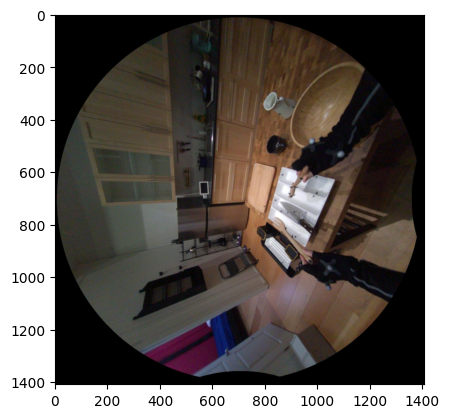

In [8]:
# Display the first frame image as an example
image_path = f"{video_scene_dir}/{first_image_example}"
image = Image.open(image_path).convert("RGB")
image_np = np.array(image)
# Show the image
plt.imshow(image_np)


In [9]:
# generate initial masks for the first frame
masks = mask_generator.generate(image_np)

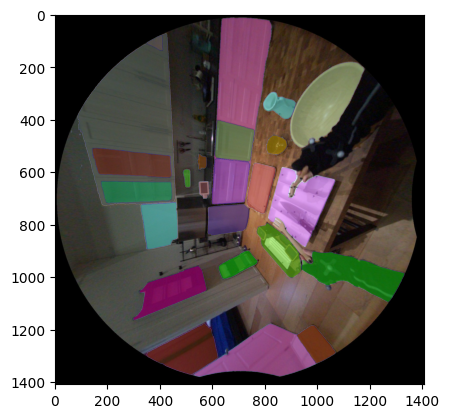

In [10]:
# Display the masks
plt.imshow(image)
show_anns(masks)
plt.show() 

In [13]:
# Create a directory to save the first-frame masks
video_name = SCENE_NAME # file structued used by vos script. we can clean this up later
init_masks_dir = f"/home/ubuntu/cs-747-project/adt_1_init_masks"
os.makedirs(os.path.join(init_masks_dir, video_name), exist_ok=True)

In [14]:
from utils.vos_inference import save_masks_to_dir, DAVIS_PALETTE

per_obj_output_mask = {
    idx: mask["segmentation"] for idx, mask in enumerate(masks)
}

# Save the mask to the output directory
save_masks_to_dir(
    init_masks_dir,
    video_name,
    first_image_example,
    per_obj_output_mask,
    height=image_np.shape[0],
    width=image_np.shape[1],
    per_obj_png_file=True,
    output_palette=DAVIS_PALETTE,
)

In [15]:
from utils.vos_inference import vos_inference
from sam2.build_sam import build_sam2_video_predictor

# sam2_checkpoint = "./sam2.1_hiera_large.pt"
# model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
# from vos_inference utils
sam2_checkpoint = "./sam2.1_hiera_base_plus.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml" 

# Whether use separate per-object PNG files for input and output masks. This is used by SA-V dataset.
# I think we want this for EgoLifter?
per_obj_png_file = True

# if we use per-object PNG files, they could possibly overlap in inputs and outputs
hydra_overrides_extra = [
    "++model.non_overlap_masks=" + ("false" if per_obj_png_file else "true")
]

predictor = build_sam2_video_predictor(
    config_file=model_cfg,
    ckpt_path=sam2_checkpoint,
    apply_postprocessing=False, # TODO experiment with true
    hydra_overrides_extra=hydra_overrides_extra,
    vos_optimized=True,
)

Image encoder compilation is enabled. First forward pass will be slow.
Compiling all components for VOS setting. First time may be very slow.


In [16]:
base_video_dir = f"/home/ubuntu/cs-747-project/adt_0_input_video"
init_masks_dir = f"/home/ubuntu/cs-747-project/adt_1_init_masks"
output_masks_dir = f"/home/ubuntu/cs-747-project/adt_2_masks"

# Make sure the output directory exists
os.makedirs(os.path.join(output_masks_dir, video_name), exist_ok=True)

In [18]:
video_dir = os.path.join(base_video_dir, video_name)
print(f"loading video frames from {video_dir}")

# Try using the new VOS inference function (TODO later try the interference per object function)
vos_inference(
    predictor=predictor,
    base_video_dir=base_video_dir,
    input_mask_dir=init_masks_dir,
    output_mask_dir=output_masks_dir,
    video_name=video_name,
    # score_thresh=0.0,
    # Just do first frame for now. But we will want to experiment with more frames later
    use_all_masks=False,
    # I beleive we want this to be True for EgoLifter. So that each object is a separate PNG file for the mask.
    per_obj_png_file=True,
)

loading video frames from /home/ubuntu/cs-747-project/adt_0_input_video/Apartment_release_golden_skeleton_seq100_10s_sample
loading video frames from /home/ubuntu/cs-747-project/adt_0_input_video/Apartment_release_golden_skeleton_seq100_10s_sample


frame loading (JPEG): 100%|██████████| 267/267 [00:10<00:00, 24.87it/s]
AUTOTUNE mm(2x2, 2x128)
  triton_mm_0 0.0041 ms 100.0% ACC_TYPE='tl.float32', ALLOW_TF32=True, BLOCK_K=16, BLOCK_M=16, BLOCK_N=32, B_PROLOGUE_CAST_TYPE=None, EVEN_K=False, GROUP_M=8, num_stages=1, num_warps=2
  triton_mm_1 0.0041 ms 100.0% ACC_TYPE='tl.float32', ALLOW_TF32=True, BLOCK_K=16, BLOCK_M=16, BLOCK_N=32, B_PROLOGUE_CAST_TYPE=None, EVEN_K=False, GROUP_M=8, num_stages=2, num_warps=2
  triton_mm_2 0.0041 ms 100.0% ACC_TYPE='tl.float32', ALLOW_TF32=True, BLOCK_K=16, BLOCK_M=16, BLOCK_N=64, B_PROLOGUE_CAST_TYPE=None, EVEN_K=False, GROUP_M=8, num_stages=5, num_warps=4
  triton_mm_3 0.0041 ms 100.0% ACC_TYPE='tl.float32', ALLOW_TF32=True, BLOCK_K=16, BLOCK_M=16, BLOCK_N=32, B_PROLOGUE_CAST_TYPE=None, EVEN_K=False, GROUP_M=8, num_stages=5, num_warps=2
  triton_mm_4 0.0041 ms 100.0% ACC_TYPE='tl.float32', ALLOW_TF32=True, BLOCK_K=16, BLOCK_M=16, BLOCK_N=64, B_PROLOGUE_CAST_TYPE=None, EVEN_K=False, GROUP_M=8, num_s

# All objects in one image


In [19]:
# Create a directory to save the first-frame masks
video_name = SCENE_NAME # file structued used by vos script. we can clean this up later
init_masks_dir = f"/home/ubuntu/cs-747-project/adt_1_init_masks_temp"
os.makedirs(os.path.join(init_masks_dir, video_name), exist_ok=True)

In [20]:
from utils.vos_inference import save_masks_to_dir, DAVIS_PALETTE

# generate initial masks for the first frame
masks = mask_generator.generate(image_np)


per_obj_output_mask = {
    idx: mask["segmentation"] for idx, mask in enumerate(masks)
}

# Save the mask to the output directory
save_masks_to_dir(
    init_masks_dir,
    video_name,
    first_image_example,
    per_obj_output_mask,
    height=image_np.shape[0],
    width=image_np.shape[1],
    per_obj_png_file=False,
    output_palette=DAVIS_PALETTE,
)

In [21]:
video_dir = os.path.join(base_video_dir, video_name)
print(f"loading video frames from {video_dir}")

# Try using the new VOS inference function (TODO later try the interference per object function)
vos_inference(
    predictor=predictor,
    base_video_dir=base_video_dir,
    input_mask_dir=init_masks_dir,
    output_mask_dir=output_masks_dir,
    video_name=video_name,
    # score_thresh=0.0,
    # Just do first frame for now. But we will want to experiment with more frames later
    use_all_masks=False,
    # Here, we try NOT using the per-object PNG files. 
    per_obj_png_file=False,
)

loading video frames from /home/ubuntu/cs-747-project/adt_0_input_video/Apartment_release_golden_skeleton_seq100_10s_sample
loading video frames from /home/ubuntu/cs-747-project/adt_0_input_video/Apartment_release_golden_skeleton_seq100_10s_sample


propagate in video: 100%|██████████| 267/267 [01:45<00:00,  2.52it/s]


In [24]:
# Save the frames as a video
import cv2
import os
import glob
import imageio
import numpy as np
from tqdm import tqdm

def save_video_from_frames(frame_dir, output_path, fps=30):
    # Get all the image files in the directory
    images = sorted(glob.glob(os.path.join(frame_dir, "*.png")), key=lambda x: int(os.path.basename(x).split(".")[0]))

    # Check if there are any images
    if not images:
        print("No images found in the directory.")
        return
    
    # Read the images and convert them to a format suitable for video
    frames = []
    for img_path in tqdm(images, desc="Reading images"):
        img = Image.open(img_path).convert("RGB")
        frames.append(np.array(img))

    imageio.mimwrite(output_path, frames, fps=fps, codec='libx264', quality=8)
    
    print(f"Video saved to {output_path}")

# Example usage
frame_dir = os.path.join(output_masks_dir, video_name)
output_path = os.path.join(output_masks_dir, f"{video_name}.mp4")
save_video_from_frames(frame_dir, output_path, fps=30)


Reading images: 100%|██████████| 267/267 [00:02<00:00, 109.50it/s]


Video saved to /home/ubuntu/cs-747-project/adt_2_masks/Apartment_release_golden_skeleton_seq100_10s_sample.mp4
